In [1]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from dataset_path import output_path
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import os
from sklearn import metrics
from thesis_helper import *

pd.set_option('float_format', '{:.3f}'.format)
path = output_path

output_path = os.path.join(path, "Figure3")
if not os.path.exists(output_path):
    os.makedirs(output_path)
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed = 0
result_list = []

In [4]:
X_train,y_train,X_test,y_test = preprocessing(path,df_train,df_test)

Before filtering: training size = 334480 , testing size = 83620
After filtering: training size = 176213 , testing size = 44063


In [8]:
X_train.describe()
ros = RandomOverSampler(sampling_strategy='minority',random_state=8) # 6:6961
X_ros, y_ros = ros.fit_resample(X_train,y_train)

In [9]:
x_ros= X_ros[['ed_los','age','ed_sbp_last','ed_heartrate_last','ed_dbp_last', 'ed_temperature_last', 'n_medrecon', 'triage_pain', 'n_med', 'ed_o2sat_last']].describe().round(3).to_csv("my_description_after.csv")

Training time: 2.186192512512207 seconds
AUC: 0.7033002780682576
AUPRC: 0.16991583550975756
Sensitivity: 0.6100746268656716
Specificity: 0.6879458002337842
Score thresold: 0.042827677
2.5 97.5


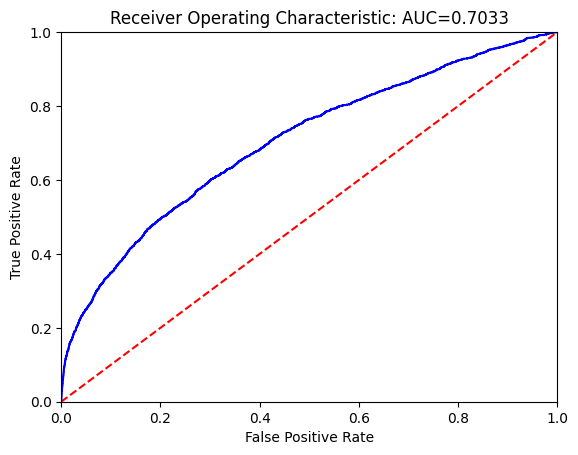

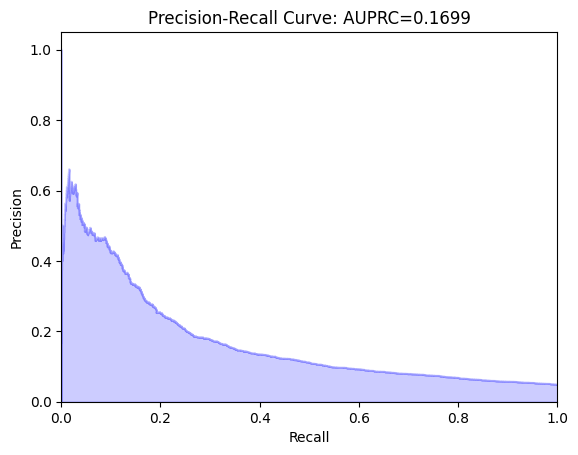

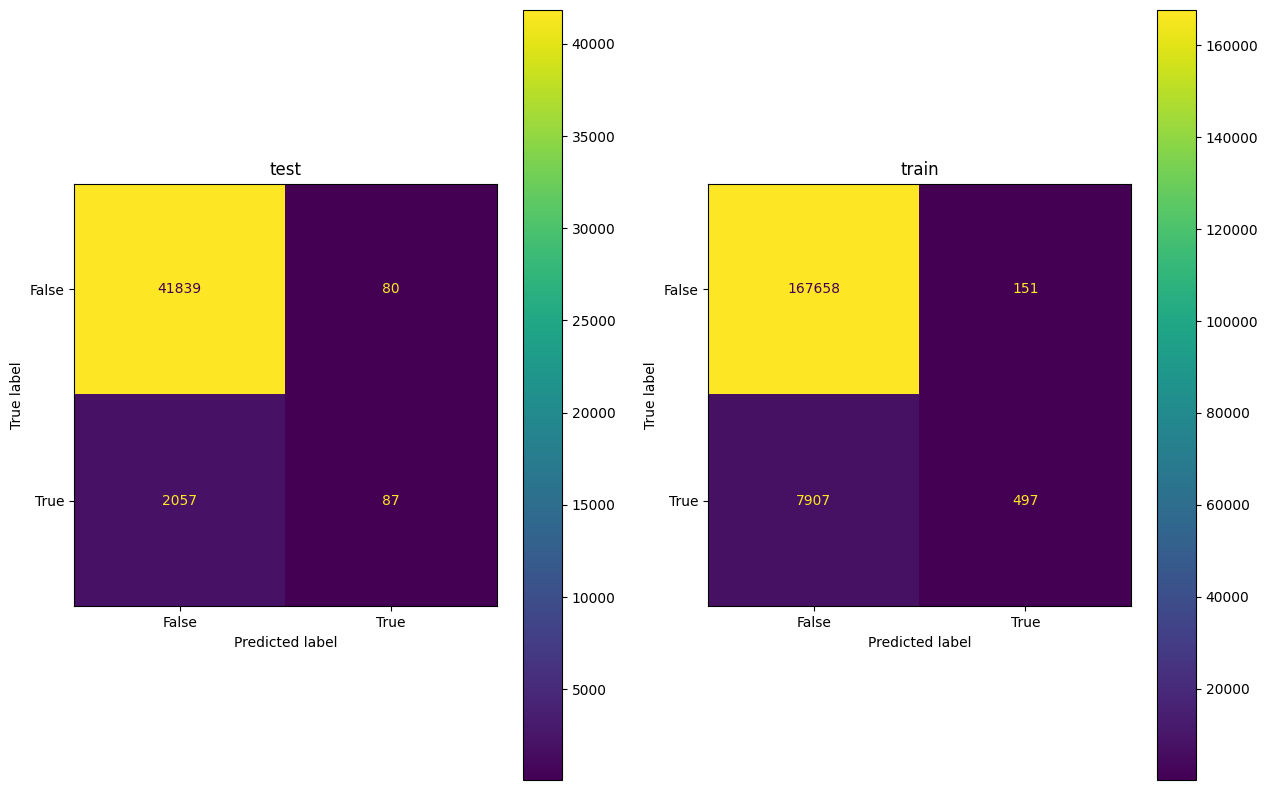

In [10]:
import lightgbm as lgb
from sklearn.svm import SVC
from catboost import CatBoostRegressor,CatBoostClassifier
from xgboost import XGBClassifier
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree',colsample_bylevel=1,
       colsample_bynode=1,colsample_bytree=1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=3, min_child_weight=1,n_estimators=250, n_jobs=20, nthread=None,
        random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
# Fit model
start = time.time()
xgb_model.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
import pickle
# with open('task3_logreg.pickle', 'wb') as model_dump:
#     pickle.dump(cat_model, model_dump)
probs = xgb_model.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["LightGbm"]
results.extend(result)
results.append(runtime)
result_list.append(results)
CM_plot_train_test(xgb_model,X_train,y_train,X_test,y_test)

In [7]:
find_sens_speci(xgb_model,X_test,y_test)

(0.07529208135006492,
 0.9515012595601752,
 0.9980915575276128,
 0.04057835820895522)

Training time: 37.30516576766968 seconds
AUC: 0.7007793136852771
AUPRC: 0.17102029463152524
Sensitivity: 0.6343283582089553
Specificity: 0.6536415467926239
Score thresold: 0.04009899377025033
2.5 97.5


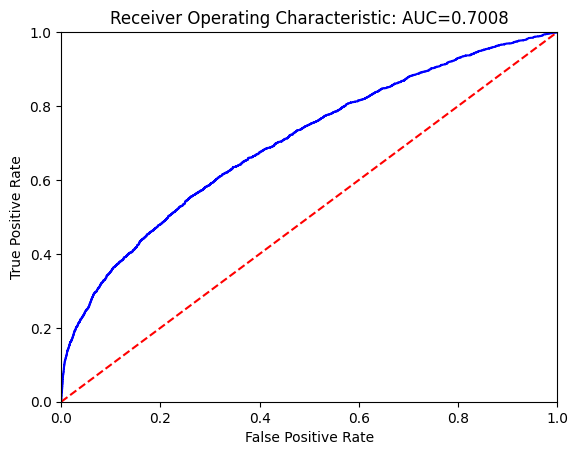

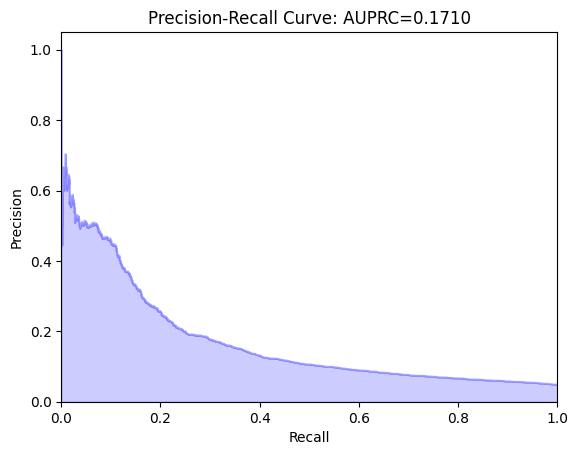

In [11]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)


In [25]:
f, accuracy1, sensitivity1, specificity1 = find_sens_speci(gb,X_test,y_test)

TypeError: type tuple doesn't define __round__ method

In [24]:
print(f, accuracy1, sensitivity1, specificity1)

0.06791467131040488 0.9514104804484488 0.9982108351821369 0.036380597014925374


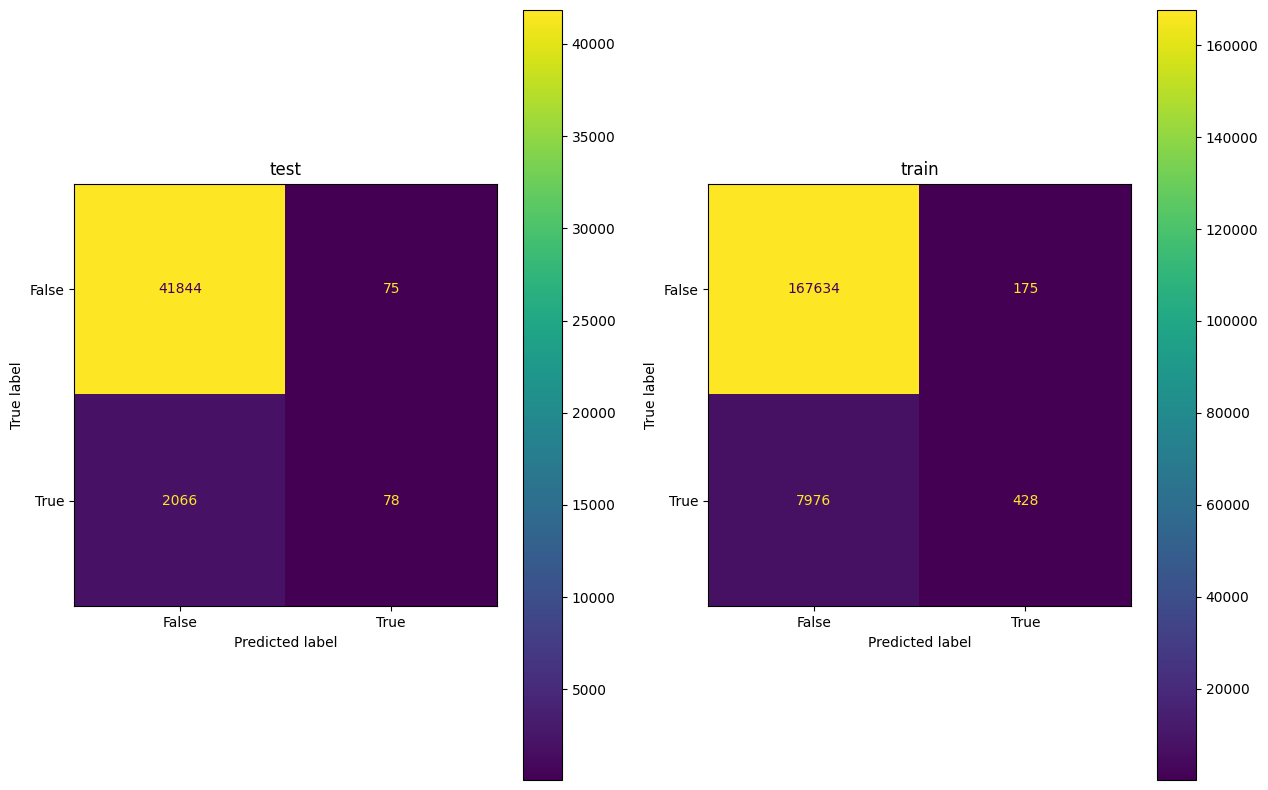

In [21]:
CM_plot_train_test(gb,X_train,y_train,X_test,y_test)

Learning rate set to 0.093755
0:	learn: 0.5713006	total: 182ms	remaining: 3m 1s
1:	learn: 0.4790345	total: 209ms	remaining: 1m 44s
2:	learn: 0.4075847	total: 256ms	remaining: 1m 25s
3:	learn: 0.3545911	total: 301ms	remaining: 1m 14s
4:	learn: 0.3143446	total: 333ms	remaining: 1m 6s
5:	learn: 0.2834878	total: 382ms	remaining: 1m 3s
6:	learn: 0.2610699	total: 413ms	remaining: 58.6s
7:	learn: 0.2436252	total: 444ms	remaining: 55s
8:	learn: 0.2300252	total: 476ms	remaining: 52.4s
9:	learn: 0.2190528	total: 509ms	remaining: 50.4s
10:	learn: 0.2103900	total: 554ms	remaining: 49.8s
11:	learn: 0.2041722	total: 585ms	remaining: 48.2s
12:	learn: 0.1987157	total: 618ms	remaining: 46.9s
13:	learn: 0.1942558	total: 648ms	remaining: 45.6s
14:	learn: 0.1908289	total: 679ms	remaining: 44.6s
15:	learn: 0.1880402	total: 710ms	remaining: 43.7s
16:	learn: 0.1859367	total: 757ms	remaining: 43.8s
17:	learn: 0.1842473	total: 803ms	remaining: 43.8s
18:	learn: 0.1827227	total: 833ms	remaining: 43s
19:	learn: 0

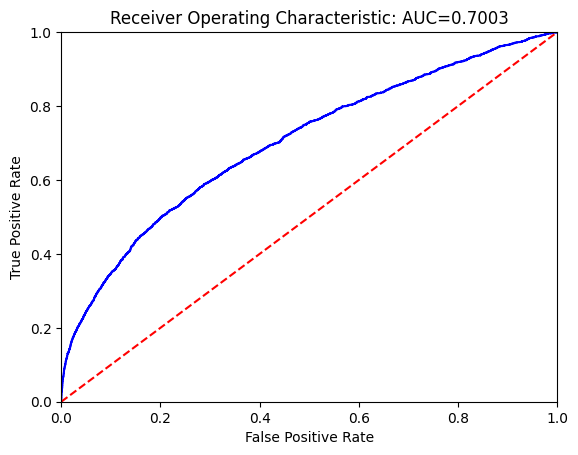

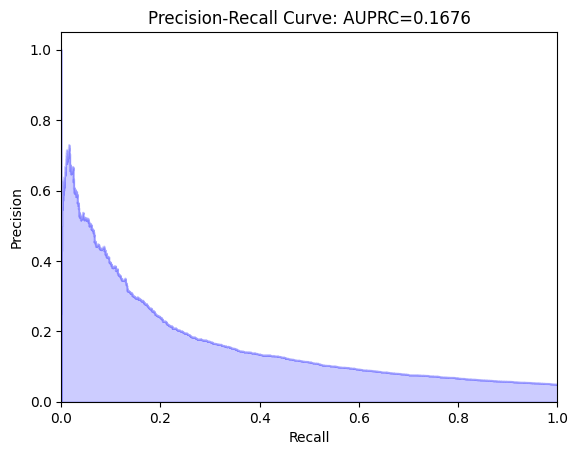

In [12]:
from sklearn.svm import SVC
from catboost import CatBoostRegressor,CatBoostClassifier

cat_model = CatBoostClassifier()
# Fit model
start = time.time()
cat_model.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
import pickle
with open('task3_logreg.pickle', 'wb') as model_dump:
    pickle.dump(cat_model, model_dump)
probs = cat_model.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["CatBoost"]
results.extend(result)
results.append(runtime)
result_list.append(results)
# CM_plot_train_test(cat_model,X_train,y_train,X_test,y_test)

In [57]:

yp = cat_model.predict(X_test)
arr = []
for x in yp:
    if x == 'True':
        arr.append(True)
    else:
        arr.append(False)
y_t = y_test.to_numpy()
cm1 = confusion_matrix(y_t,arr)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])

f = f1_score(y_t,arr)

print(f, accuracy1, sensitivity1, specificity1)
# f, accuracy1, sensitivity1, specificity1 = find_sens_speci(cat_model,X_test,y_test)

0.09260832625318606 0.9515239543381068 0.9975905913786112 0.05083955223880597


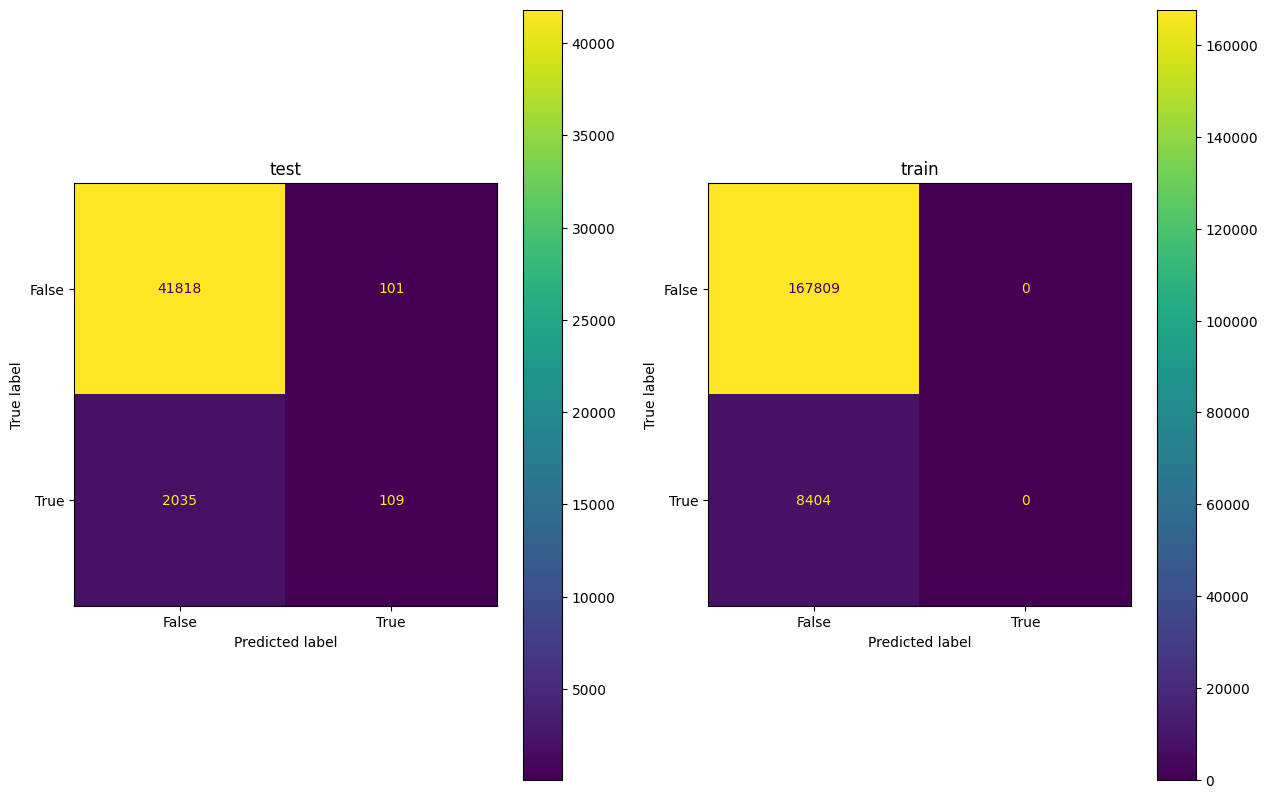

In [61]:
new_probs_train = cat_model.predict(X_train)
new_probs_train
    # cm1 = metrics.confusion_matrix(y_train,new_probs_train)
    # train_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = [False, True])
    # train_cm_display.plot()
new_probs_train = np.array(new_probs_train, dtype=bool)
new_probs_test = cat_model.predict(X_test)
new_probs_test = np.array(new_probs_test, dtype=bool)
# cm1 = metrics.confusion_matrix(y_test,new_probs_test)
# train_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = [False, True])
# train_cm_display.plot()
arr_train = []
for x in new_probs_train:
    if x == 'True':
        arr_train.append(True)
    else:
        arr_train.append(False)

y_train11 = y_train.to_numpy()
fig, ax = plt.pyplot.subplots(1, 2,figsize=(15,10))
ax[0].set_title("test")
ax[1].set_title("train")

metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(y_t, arr), 
    display_labels=[False, True]).plot(ax=ax[0])

metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(y_train11, arr_train), 
    display_labels=[False, True]).plot(ax=ax[1])

[LightGBM] [Info] Number of positive: 8404, number of negative: 167809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 176213, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.047692 -> initscore=-2.994119
[LightGBM] [Info] Start training from score -2.994119
Training time: 0.9252016544342041 seconds
AUC: 0.7025443614960337
AUPRC: 0.17101054030528978
Sensitivity: 0.6147388059701493
Specificity: 0.6780218993773706
Score thresold: 0.042185725547609625
2.5 97.5


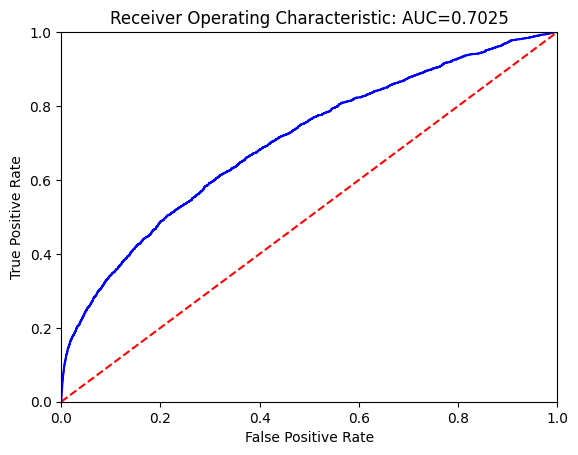

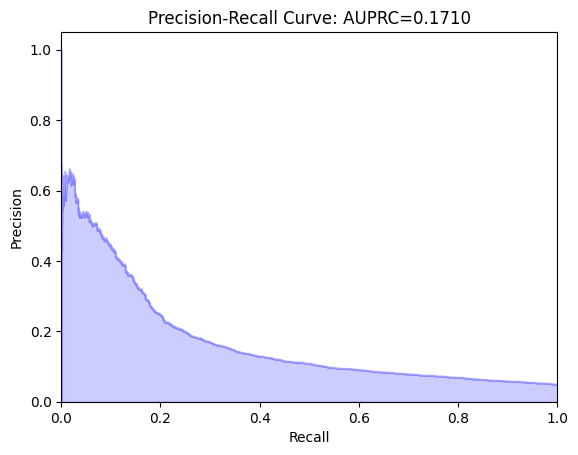

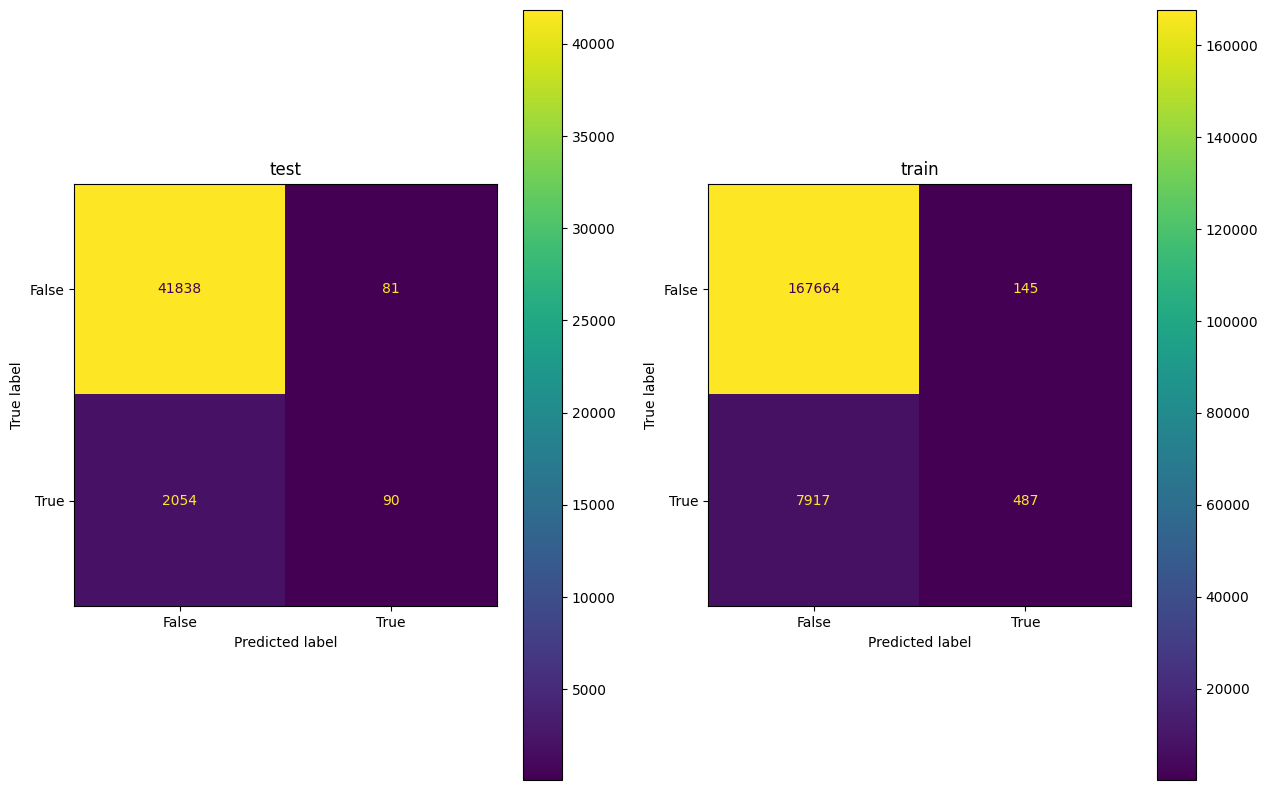

In [13]:
import lightgbm as lgb
from sklearn.svm import SVC

lgb_model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=45)
# Fit model
start = time.time()
lgb_model.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = lgb_model.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["LightGbm"]
results.extend(result)
results.append(runtime)
result_list.append(results)
CM_plot_train_test(lgb_model,X_train,y_train,X_test,y_test)

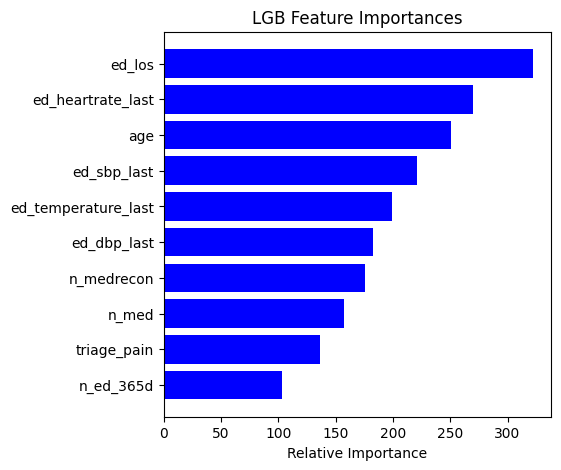

In [25]:
features = X_train.columns
importances = lgb_model.feature_importances_
indices = np.argsort(importances)

# customized number 
num_features = 10 

plt.figure(figsize=(5,5))
plt.title('LGB Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

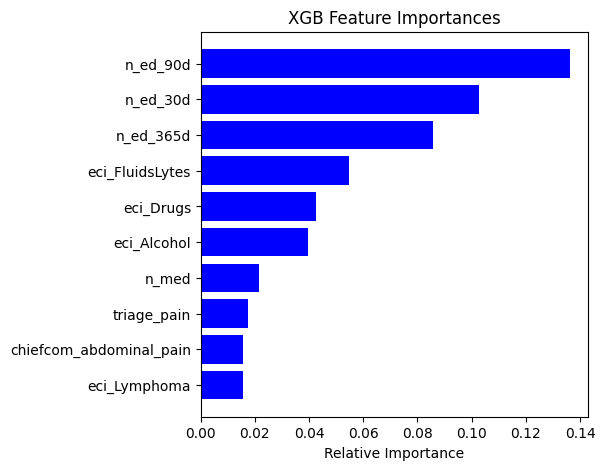

In [22]:
features = X_train.columns
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

# customized number 
num_features = 10 

plt.figure(figsize=(5,5))
plt.title('XGB Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

In [26]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

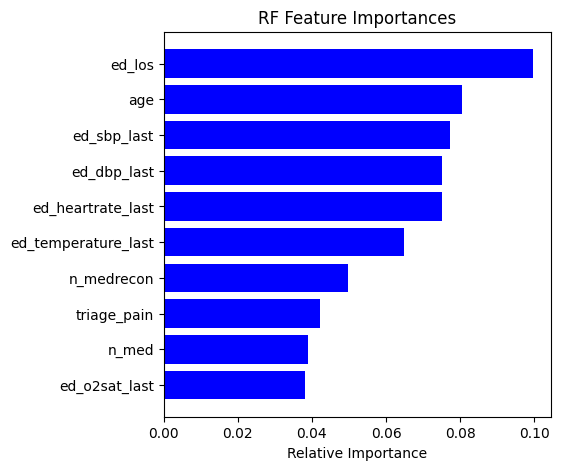

In [27]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

# customized number 
num_features = 10 

plt.figure(figsize=(5,5))
plt.title('RF Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

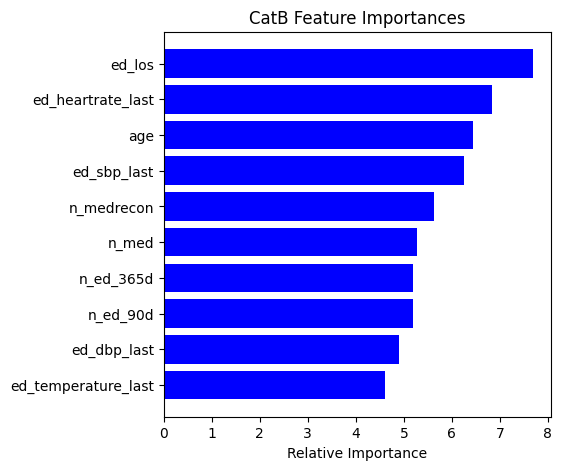

In [24]:
features = X_train.columns
importances = cat_model.feature_importances_
indices = np.argsort(importances)

# customized number 
num_features = 10 

plt.figure(figsize=(5,5))
plt.title('CatB Feature Importances')

# only plot the customized number of features
plt.barh(range(num_features), importances[indices[-num_features:]], color='b', align='center')
plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
plt.xlabel('Relative Importance')
plt.show()

In [63]:
find_sens_speci(lgb_model,X_test,y_test)

(0.0777537796976242,
 0.9515466491160384,
 0.9980677019967079,
 0.04197761194029851)

[LightGBM] [Info] Number of positive: 8404, number of negative: 167809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 176213, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.047692 -> initscore=-2.994119
[LightGBM] [Info] Start training from score -2.994119
0:	learn: 0.2343566	total: 16.1ms	remaining: 952ms
1:	learn: 0.1868986	total: 29.3ms	remaining: 849ms
2:	learn: 0.1799518	total: 42.4ms	remaining: 805ms
3:	learn: 0.1783925	total: 55.6ms	remaining: 778ms
4:	learn: 0.1774882	total: 68.9ms	remaining: 758ms
5:	learn: 0.1774117	total: 82.8ms	remaining: 745ms
6:	learn: 0.1772001	total: 95.1ms	remaining: 720ms
7:	learn: 0.1768819	total: 109ms	remaining: 709ms
8:	learn: 0.1767073	total: 123ms	r

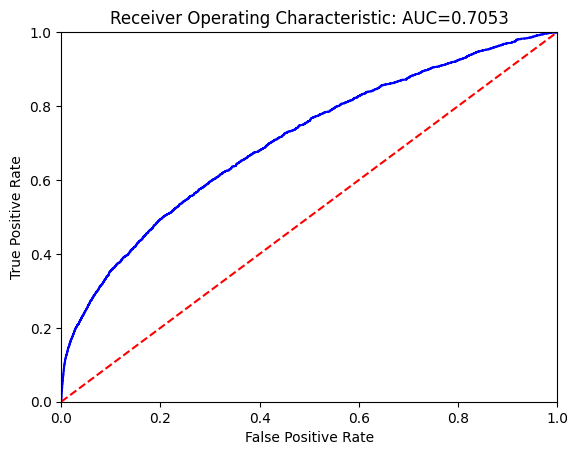

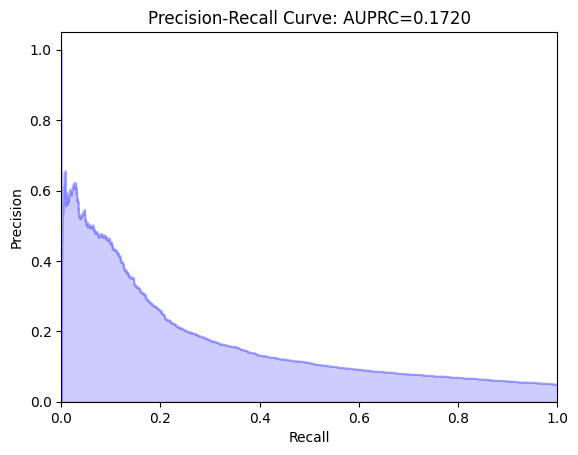

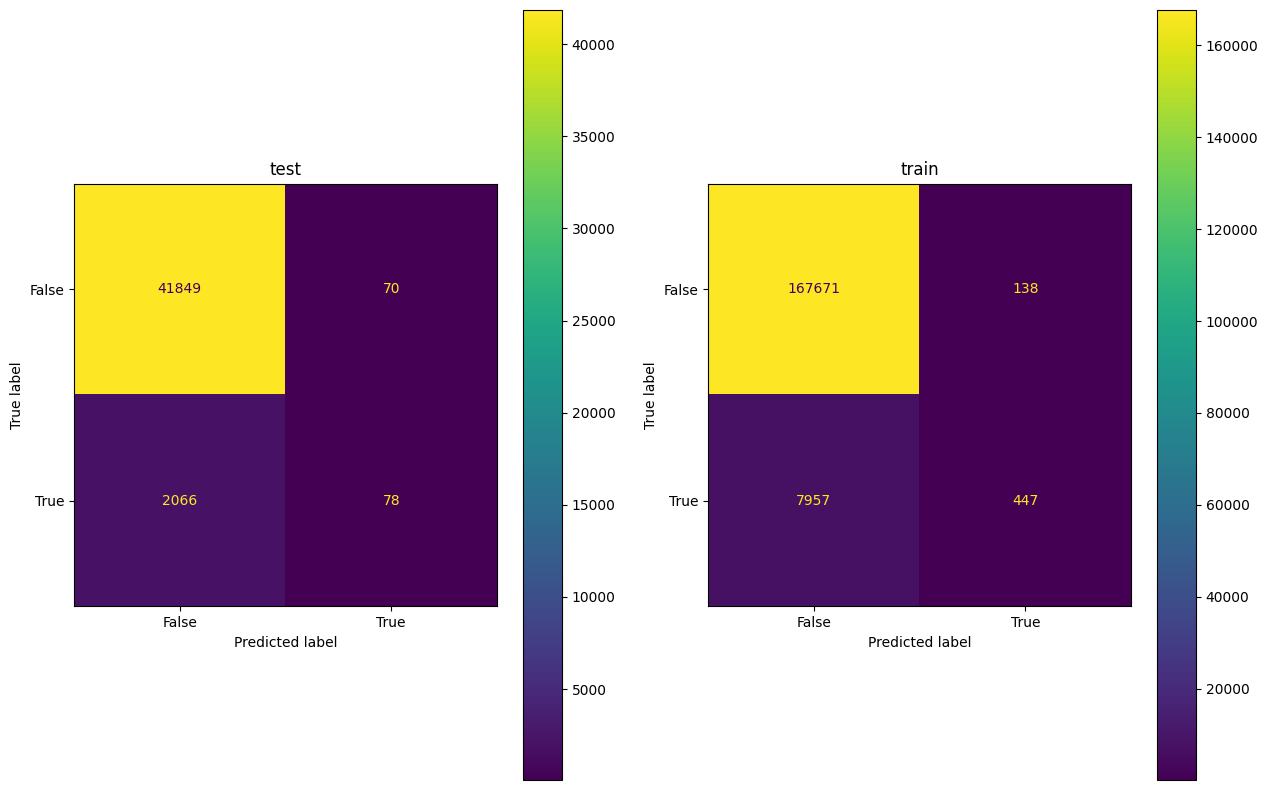

In [14]:
import lightgbm as lgb
import imblearn
from imblearn.pipeline import Pipeline
from catboost import CatBoostRegressor,CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import NearMiss

from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
start = time.time()
clf1 = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=45)
clf2 = CatBoostClassifier(iterations=60,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass',random_state=45)
clf3 = XGBClassifier(base_score=0.5, booster='gbtree',colsample_bylevel=1,
       colsample_bynode=1,colsample_bytree=1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=3, min_child_weight=1,n_estimators=250, n_jobs=20, nthread=None,
        random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


eclf = VotingClassifier(estimators=[('LGB', clf1), ('CatB', clf2), ('XGB', clf3)],voting='soft',weights = [1,1,1])
eclf.fit(X_train,y_train)
runtime = time.time()-start
probs = eclf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["Ensemble classfier"]
results.extend(result)
results.append(runtime)
result_list.append(results)
CM_plot_train_test(eclf,X_train,y_train,X_test,y_test)

C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 8404, number of negative: 167809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1472
[LightGBM] [Info] Number of data points in the train set: 176213, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.047692 -> initscore=-2.994119
[LightGBM] [Info] Start training from score -2.994119
0:	learn: 0.2343566	total: 17.7ms	remaining: 1.04s
1:	learn: 0.1868986	total: 30.9ms	remaining: 896ms
2:	learn: 0.1799518	total: 43.6ms	remaining: 827ms
3:	learn: 0.1783925	total: 54.8ms	remaining: 768ms
4:	learn: 0.1774882	total: 67ms	remaining: 737ms
5:	learn: 0.1774117	total: 78.5ms	remaining: 706ms
6:	learn: 0.1772001	total: 90.9ms	remaining: 688ms
7:	learn: 0.1768819	total: 103ms	remaining: 667ms
8:	learn: 0.1767073	total: 114ms	rem

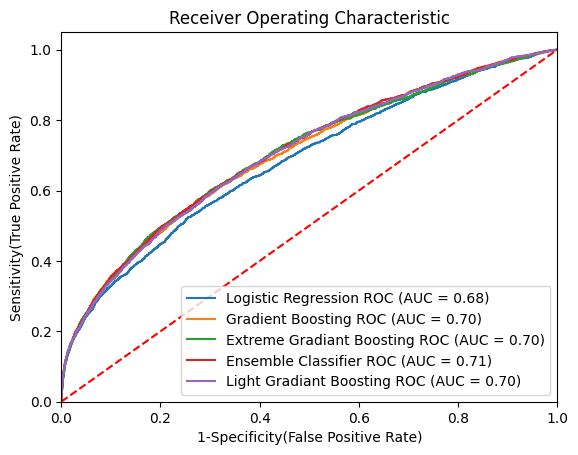

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure()

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Gradient Boosting',
    'model': gb,
},
{
    'label': 'Extreme Gradiant Boosting',
    'model': xgb_model,
},
{
    'label': 'Ensemble Classifier',
    'model': eclf,
},
{
    'label': 'Light Gradiant Boosting',
    'model': lgb_model,
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s ROC (AUC = %0.2f)' % (m['label'], roc_auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

In [65]:
find_sens_speci(eclf,X_test,y_test)

(0.0680628272251309,
 0.9515239543381068,
 0.9983301128366612,
 0.036380597014925374)

In [88]:
from sklearn.metrics import confusion_matrix
yp = eclf.predict(X_test)
cm1 = confusion_matrix(y_test,yp)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[41849    70]
 [ 2066    78]]
Accuracy :  0.9515239543381068
Sensitivity :  0.9983301128366612
Specificity :  0.036380597014925374


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from feature_engine.selection import SelectBySingleFeaturePerformance
from catboost import CatBoostRegressor,CatBoostClassifier
import lightgbm as lgb
sel = SelectBySingleFeaturePerformance(
    estimator=CatBoostClassifier(iterations=60,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass',random_state=45),
    scoring='roc_auc',
    cv=3,
    threshold=None,
)

X_train_t = sel.fit_transform(X_train, y_train)
X_test_t = sel.transform(X_test)

0:	learn: 0.2379867	total: 12.8ms	remaining: 757ms
1:	learn: 0.1957981	total: 21.7ms	remaining: 629ms
2:	learn: 0.1913968	total: 28.9ms	remaining: 549ms
3:	learn: 0.1908999	total: 36.3ms	remaining: 509ms
4:	learn: 0.1908570	total: 43.8ms	remaining: 482ms
5:	learn: 0.1907990	total: 51.4ms	remaining: 462ms
6:	learn: 0.1907882	total: 58.4ms	remaining: 442ms
7:	learn: 0.1907662	total: 65.8ms	remaining: 428ms
8:	learn: 0.1907513	total: 72.8ms	remaining: 413ms
9:	learn: 0.1906947	total: 81.6ms	remaining: 408ms
10:	learn: 0.1906834	total: 88.5ms	remaining: 394ms
11:	learn: 0.1906639	total: 95.6ms	remaining: 382ms
12:	learn: 0.1906388	total: 103ms	remaining: 373ms
13:	learn: 0.1906330	total: 110ms	remaining: 363ms
14:	learn: 0.1906262	total: 118ms	remaining: 354ms
15:	learn: 0.1906224	total: 126ms	remaining: 347ms
16:	learn: 0.1906202	total: 134ms	remaining: 338ms
17:	learn: 0.1906118	total: 141ms	remaining: 329ms
18:	learn: 0.1906066	total: 148ms	remaining: 320ms
19:	learn: 0.1905901	total: 1

[LightGBM] [Info] Number of positive: 167809, number of negative: 167809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 335618, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0:	learn: 0.6481029	total: 26.4ms	remaining: 1.56s
1:	learn: 0.6396163	total: 48.8ms	remaining: 1.41s
2:	learn: 0.6361084	total: 75.4ms	remaining: 1.43s
3:	learn: 0.6344335	total: 98.5ms	remaining: 1.38s
4:	learn: 0.6326050	total: 121ms	remaining: 1.33s
5:	learn: 0.6307414	total: 144ms	remaining: 1.3s
6:	learn: 0.6297749	total: 168ms	remaining: 1.27s
7:	learn: 0.6286643	total: 189ms	remaining: 1.23s
8:	learn: 0.6280883	total: 209ms	remaining: 1.18s
9:	learn: 0.6273329	total: 229ms	remaining

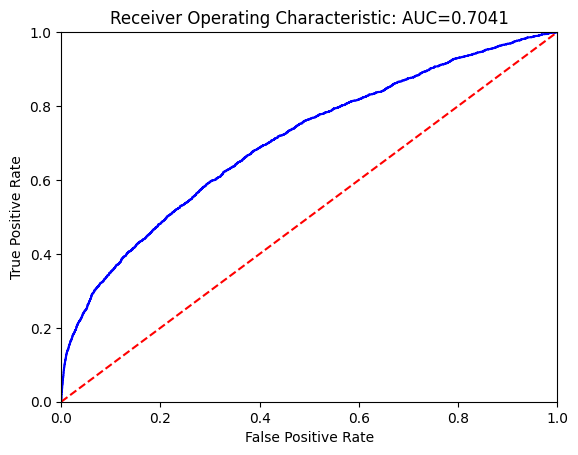

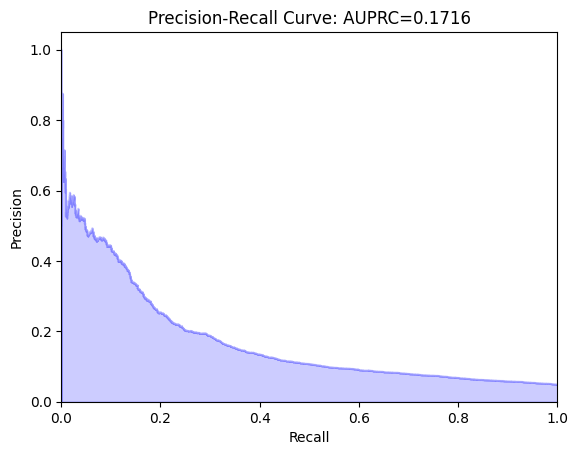

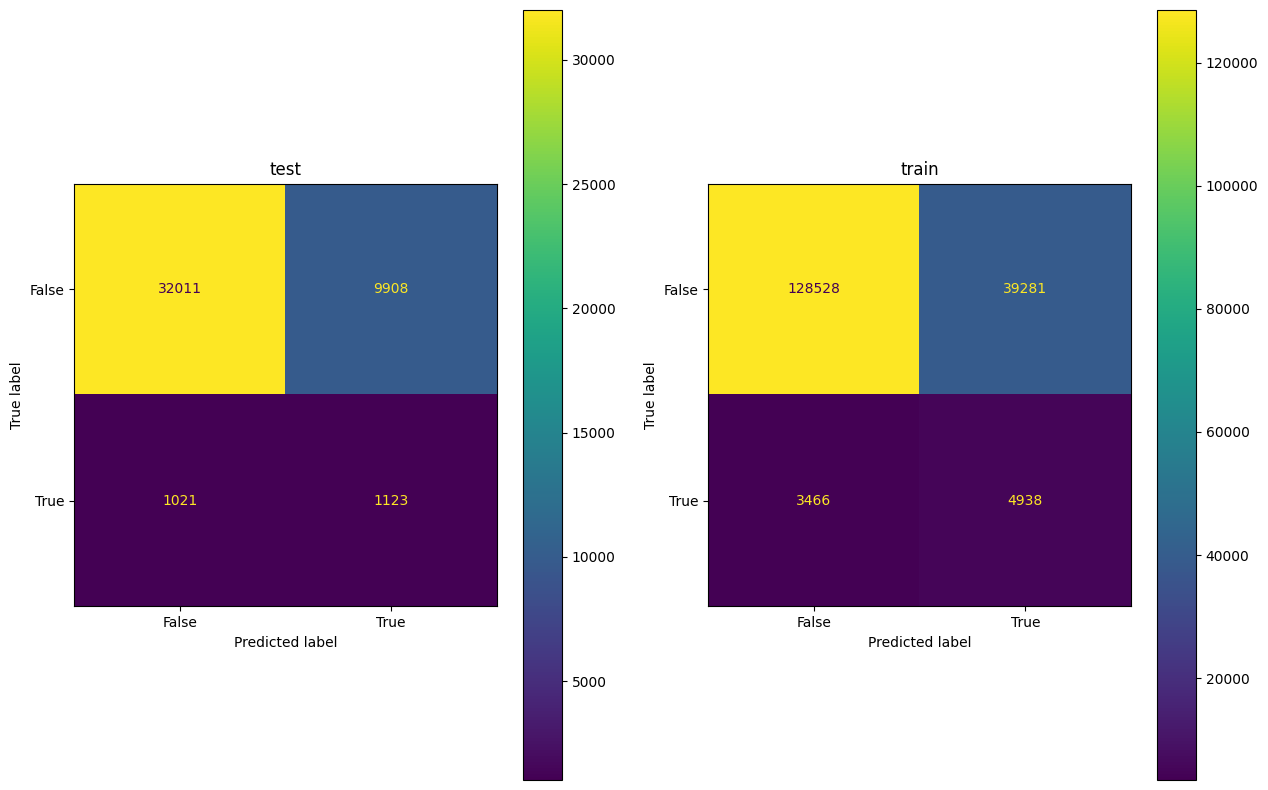

In [89]:
import lightgbm as lgb
import imblearn
from imblearn.pipeline import Pipeline
from catboost import CatBoostRegressor,CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import NearMiss

from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
# X_ros, y_ros = X_new,y_train
ros = RandomOverSampler(sampling_strategy='minority',random_state=8) # 6:6961
X_ros, y_ros = ros.fit_resample(X_train_t,y_train)
clf1 = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=45)
clf2 = CatBoostClassifier(iterations=60,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass',random_state=45)
clf3 = XGBClassifier(base_score=0.5, booster='gbtree',colsample_bylevel=1,
       colsample_bynode=1,colsample_bytree=1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=3, min_child_weight=1,n_estimators=250, n_jobs=20, nthread=None,
        random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


eclf = VotingClassifier(estimators=[('LGB', clf1), ('CatB', clf2), ('XGB', clf3)],voting='soft',weights = [1,1,1])
eclf.fit(X_ros,y_ros)
probs = eclf.predict_proba(X_test_t)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
# results = ["Ensemble classfier"]
# results.extend(result)
# results.append(runtime)
# result_list.append(results)
CM_plot_train_test(eclf,X_train_t,y_train,X_test_t,y_test)

In [91]:
from sklearn.metrics import confusion_matrix
yp = eclf.predict(X_test_t)
cm1 = confusion_matrix(y_test,yp)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[32011  9908]
 [ 1021  1123]]
Accuracy :  0.7519687719855661
Sensitivity :  0.7636393997948424
Specificity :  0.5237873134328358


In [81]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task3.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,GB,0.040,0.701 (0.692-0.711),0.171 (0.164-0.186),0.634 (0.603-0.648),0.654 (0.649-0.684),37.790
1,CatBoost,0.040,0.7 (0.691-0.711),0.168 (0.16-0.184),0.633 (0.597-0.652),0.661 (0.636-0.706),35.740
2,LightGbm,0.042,0.703 (0.693-0.714),0.171 (0.162-0.186),0.615 (0.606-0.668),0.678 (0.627-0.698),0.741
3,Ensemble classfier,0.042,0.705 (0.696-0.717),0.172 (0.163-0.187),0.621 (0.607-0.652),0.673 (0.631-0.693),0.741


In [126]:
from sklearn.model_selection import cross_val_score, GridSearchCV
params = {'voting':['soft'],
          'weights':[(1,1,1),(1,3,1),(2,4,1),(2,5,1),(1,6,1),(1,2,1),(1,1,3)]}

#fit gridsearch & print best params
grid = GridSearchCV(eclf, params,cv=5,scoring='roc_auc')
grid.fit(X_ros,y_ros)
print('\n')
print(f'The best params is : {grid.best_params_}')

[LightGBM] [Info] Number of positive: 134247, number of negative: 134247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 883
[LightGBM] [Info] Number of data points in the train set: 268494, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0:	learn: 0.6478838	total: 19.5ms	remaining: 1.15s
1:	learn: 0.6395245	total: 37.4ms	remaining: 1.08s
2:	learn: 0.6359824	total: 57.2ms	remaining: 1.09s
3:	learn: 0.6341644	total: 73.5ms	remaining: 1.03s
4:	learn: 0.6318712	total: 89.9ms	remaining: 989ms
5:	learn: 0.6308647	total: 106ms	remaining: 956ms
6:	learn: 0.6301579	total: 124ms	remaining: 939ms
7:	learn: 0.6292027	total: 142ms	remaining: 925ms
8:	learn: 0.6281409	total: 165ms	remaining: 933ms
9:	learn: 0.6274865	total: 179ms	remaini

In [129]:
tuned_eclf = VotingClassifier(estimators=[('NB', clf1), ('CB', clf2), ('LR', clf3)],**grid.best_params_, n_jobs = -1)
tuned_cvm = cross_val_score(tuned_eclf, X_ros,y_ros)
tuned_score = tuned_cvm.mean()
tuned_std = tuned_cvm.std()
print('\n')
print(f'The average tuned cross-validation score is {round(tuned_score, 4)} (+- {round(tuned_std, 4)})')




The average tuned cross-validation score is 0.6749 (+- 0.0013)


In [130]:
grid.best_params_

{'voting': 'soft', 'weights': (1, 1, 1)}

AUC: 0.7040917331506071
AUPRC: 0.17155667105588487
Sensitivity: 0.6226679104477612
Specificity: 0.6717478947493977
Score thresold: 0.45876710435393514
2.5 97.5


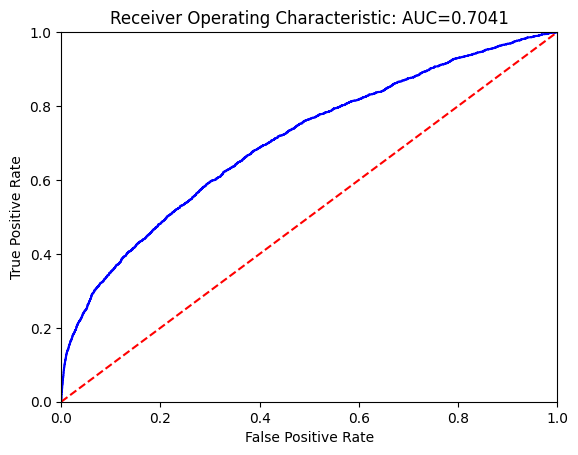

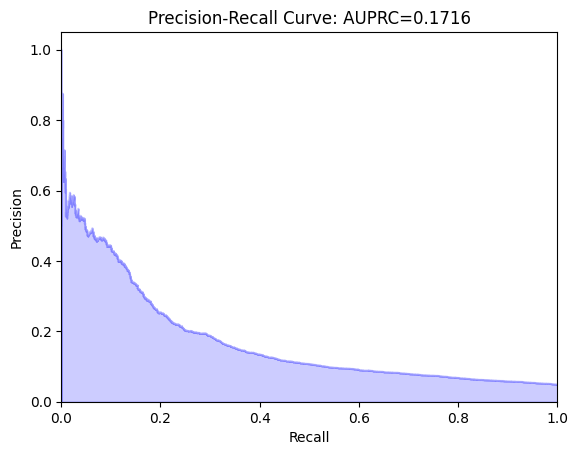

In [131]:
tuned_eclf.fit(X_ros,y_ros)
probs = tuned_eclf.predict_proba(X_test_t)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

[LightGBM] [Info] Number of positive: 167809, number of negative: 167809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 335618, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
2.5 97.5
0:	learn: 0.6481029	total: 23.3ms	remaining: 1.38s
1:	learn: 0.6396163	total: 46.8ms	remaining: 1.36s
2:	learn: 0.6361084	total: 67.2ms	remaining: 1.28s
3:	learn: 0.6344335	total: 88.8ms	remaining: 1.24s
4:	learn: 0.6326050	total: 110ms	remaining: 1.21s
5:	learn: 0.6307414	total: 135ms	remaining: 1.22s
6:	learn: 0.6297749	total: 161ms	remaining: 1.22s
7:	learn: 0.6286643	total: 186ms	remaining: 1.21s
8:	learn: 0.6280883	total: 215ms	remaining: 1.22s
9:	learn: 0.6273329	total: 241ms

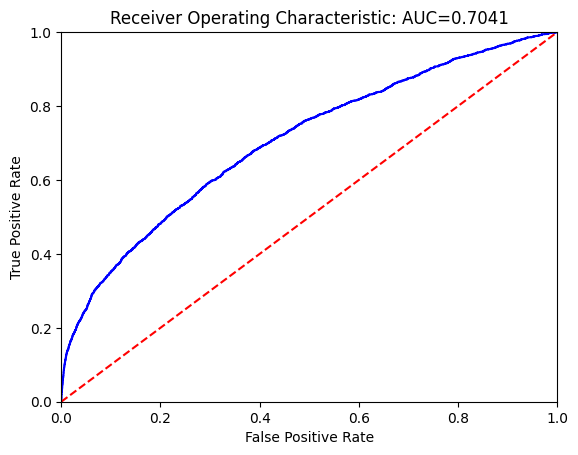

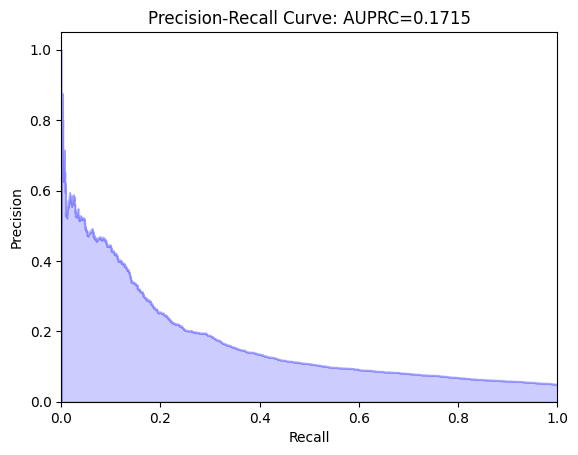

In [90]:
from sklearn.metrics import auc
def get_models():
    models = list()
    models.append(('knn', clf1))
    models.append(('cart', clf2))
    models.append(('svm', clf3))
    return models

# evaluate each base model
def evaluate_models(models, X_train, X_val, y_train, y_val):
    # fit and evaluate the models
    scores = list()
    for name, model in models:
    # fit the model
        model.fit(X_train, y_train)
        # evaluate the model
        yhat = model.predict_proba(X_val)
        results = ROC_result(yhat[:,1],y_val, ci=confidence_interval, random_seed=random_seed)
        au = results[0]
        # store the performance
        scores.append(au)
    # report model performance
    return scores
models = get_models()
scores = evaluate_models(models, X_ros, X_test_t, y_ros, y_test)
tuned_eclf = VotingClassifier(estimators=[('NB', clf1), ('CB', clf2), ('LR', clf3)], voting='soft',weights = scores, n_jobs = -1)
# tuned_cvm = cross_val_score(tuned_eclf, X_ros,y_ros)
# tuned_score = tuned_cvm.mean()
# tuned_std = tuned_cvm.std()
# print('\n')
# print(f'The average tuned cross-validation score is {round(tuned_score, 4)} (+- {round(tuned_std, 4)})')
tuned_eclf.fit(X_ros,y_ros)
probs = tuned_eclf.predict_proba(X_test_t)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
# CM_plot_train_test(eclf,X_train,y_train,X_test,y_test)

In [91]:
print(scores)

[0.697206157940349, 0.7016736234913602, 0.698714447247766]


In [ ]:
# Lasso regularization
# recursive feature elmination

# X_ros,y_ros = X_train,y_train
# Random Oversampling
# SMOTE
# Borderline SMOTE
# SVM SMote
# k-Means SMOTE
# ADASYN

# Methods that Select Examples to Keep
# Near Miss Undersampling
# Condensed Nearest Neighbor Rule for Undersampling
# Methods that Select Examples to Delete
# Tomek Links for Undersampling
# Edited Nearest Neighbors Rule for Undersampling
# Combinations of Keep and Delete Methods
# One-Sided Selection for Undersampling
# Neighborhood Cleaning Rule for Undersampling

Dividing variable into groups

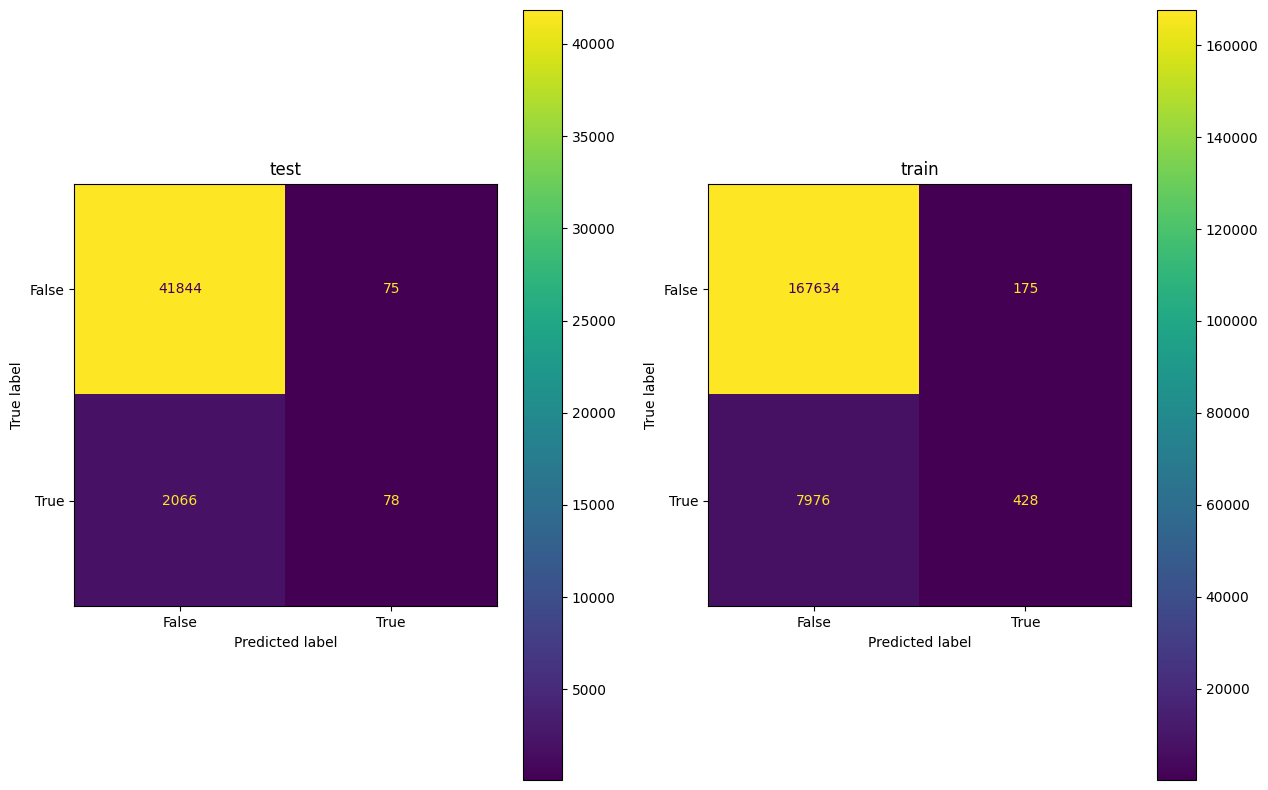

In [37]:
CM_plot_train_test(gb,X_train,y_train,X_test,y_test)

C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 2.3515255451202393 seconds
AUC: 0.6907045299338845
AUPRC: 0.16656283575195688
Sensitivity: 0.6156716417910447
Specificity: 0.6484648965862736
Score thresold: 0.45766337328968343
2.5 97.5


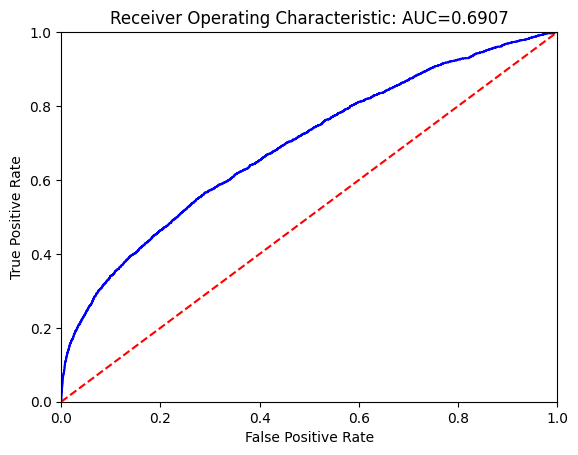

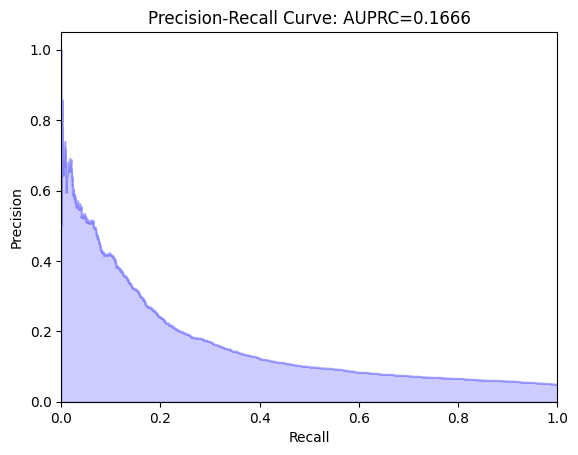

In [40]:
from sklearn.feature_selection import SelectFromModel
lo=LogisticRegression(random_state=1)
start = time.time()
lo.fit(X_ros,y_ros)
# model = SelectFromModel(lo, prefit=True)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
import pickle
with open('task3_logreg.pickle', 'wb') as model_dump:
    pickle.dump(lo, model_dump)
probs = lo.predict_proba(X_test_t)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["Logistic regression"]
results.extend(result)
results.append(runtime)
result_list.append(results)

CM for test

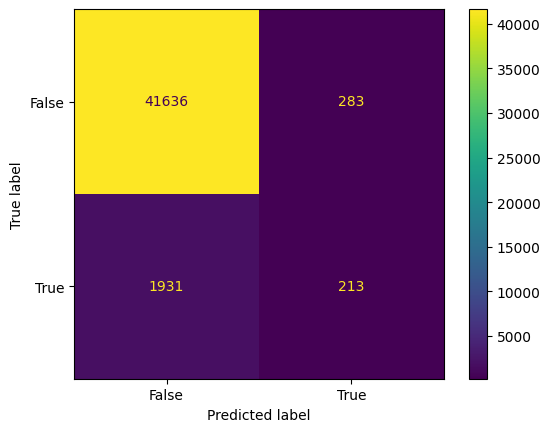

0.6618024192633275


In [ ]:
probs_em = eclf.predict(X_test)
cm1 = metrics.confusion_matrix(y_test,probs_em)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = [False, True])

cm_display.plot()
plt.savefig(path + '/confusion_matrix.png')
plt.show()
acc = metrics.accuracy_score(y_test, new_probs)
print(acc)

CM for train

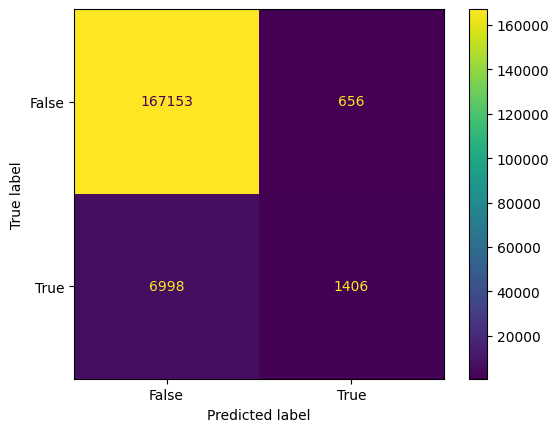

NameError: name 'new_probs' is not defined

In [10]:
probs_em = eclf.predict(X_train)
cm1 = metrics.confusion_matrix(y_train,probs_em)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = [False, True])

cm_display.plot()
plt.savefig(path + '/confusion_matrix.png')
plt.show()
acc = metrics.accuracy_score(y_test, probs_em)
print(acc)

In [11]:

result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task3.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,Logistic regression,0.044,0.682 (0.674-0.689),0.162 (0.151-0.175),0.599 (0.56-0.631),0.659 (0.629-0.702),3.063
1,CatBoost,0.040,0.7 (0.691-0.711),0.168 (0.16-0.184),0.633 (0.597-0.652),0.661 (0.636-0.706),37.521
2,GaussianNB,0.000,0.674 (0.667-0.685),0.103 (0.097-0.107),0.632 (0.586-0.652),0.621 (0.607-0.672),0.368
3,Ensemble Classfier,0.032,0.699 (0.691-0.708),0.168 (0.157-0.182),0.607 (0.599-0.645),0.693 (0.647-0.71),40.987


In [ ]:
t = 0
f = 0
for x in y_train:
    if x == True:
        t += 1
    else:
        f += 1
for x in y_test:
    if x == True:
        t += 1
    else:
        f += 1        
print(t)
print(f)